In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import osmnx as ox
import pyrosm as py
import ast

import haversine as hs
import requests
import json
import googlemaps
from datetime import datetime

from API import K

## Import data

In [2]:
df_pr=pd.read_excel('Data/P_R_Datenbank_2019_ohne.xlsx')

In [3]:
df_pr['P+R']=True
df_pr.Day_price.replace('','free',inplace=True)


## Create a random point
Random point somewhere in Munich, that might be a destination, to use to test function

In [4]:
#random point somewhere in Munich to tryout script
import random

lat_r=random.uniform(48.248116, 48.061624)
lon_r=random.uniform(11.722910, 11.360777)
latlon_r=(lat_r,lon_r)
print("Random point was selected", (lat_r,lon_r))

Random point was selected (48.235634095371275, 11.47416250853568)
<class 'tuple'>


In [5]:
def find_nearest_parking(latlon, df=df_pr, expected_arrival=datetime.now()):
    """Function to find the nearest parkingplace in Munich given a latitude, 
    longtitude or address and a dataframe with parkings that contains for each entry \
    at least a lon and lat column and optionally an expected arrival time."""
    
    
    #create new columns to fill later
    df['bird_dist'] = 0
    
    df['est_time_walking'] = 0
    df['est_time_bicycling'] = 0
    df['est_time_transit'] = 0
    
    df['est_dist_walking'] = 0
    df['est_dist_bicycling'] = 0
    df['est_dist_transit'] = 0
    
    #combine lat and lon in one column
    df['lat_lon']=list(zip(df.lat, df.lon))
    
    #calculate distance as the crow flies from dest to all parkings
    df['bird_dist'] = df.lat_lon.apply(lambda p: hs.haversine((lat_r,lon_r),p))
    
    #sort values based on bird_dist, reset index
    df.sort_values(by='bird_dist',inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    #calculate travel times to final dest for 5 parkings that are the nearest as the crow flies and add them to df
    for i in range (5):
        for j in ['walking','bicycling','transit']:
            #run google api and unpack relevant variables
            if type(latlon) is tuple:
                r = requests.get(f"https://maps.googleapis.com/maps/api/directions/json?origin={df.lat[i]},{df.lon[i]}&destination={latlon[0]},{latlon[1]}&mode={j}&key={K}")
            else:
                r = requests.get(f"https://maps.googleapis.com/maps/api/directions/json?origin={df.lat[i]},{df.lon[i]}&destination={latlon}&mode={j}&key={K}")
            #unpack
            results = json.loads(r.content)
            legs = results.get("routes").pop(0).get("legs")
            dur_dist=(legs[0].get("duration"), legs[0].get("distance"))
            #save data in previously assigned columns
            df['est_time_'+str(j)][i] = dur_dist[0]['text']
            df['est_dist_'+str(j)][i] = dur_dist[1]['text']
    
    #only first 5 are interesting, drop irrelevant columns
    df=df[:5].drop(columns=['Bahnhof','BahnhofID','GlobaleID', 'Name','Niveau,N,10,0','bird_dist','P+R','MVTT_x','MVTT_y', "Georeferenz", "Name DIVA", "lat_lon"])
    df.rename(columns={"Alternative_name": "Name"}, inplace=True)
    
    #subset availability
    availability = df.filter(regex='OCC_')
    availability = availability.join(df.loc[:,'Name'], lsuffix='_caller', rsuffix='_other')
    availability.set_index('Name', drop=True, inplace=True)
    
    #remove from other dataframe
    df.drop(list(df.filter(regex = 'OCC_')), axis = 1, inplace = True)
    return(df, availability)

In [6]:
results=find_nearest_parking(latlon_r)

C:\Users\Fabia\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Fabia\anaconda3\envs\gds\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\Fabia\anaconda3\envs\gds\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
df1=results[0]
df2=results[1]

In [14]:
df1

,Name,lon,lat,Capacity,P_women,P_family,P_invalid,Entrance,Day_price,Ticket_for_10,Month_ticket,Year_ticket,Link,est_time_walking,est_time_bicycling,est_time_transit,est_dist_walking,est_dist_bicycling,est_dist_transit
0,P+R Karlsfeld (Ost),11.461047,48.210622,105,NaN,NaN,2,Treppe,1.0,9.5,11,110,https://www.mvv-muenchen.de/plaene-bahnhoefe/b...,44 mins,12 mins,16 mins,3.6 km,3.8 km,4.8 km
1,P+R Dachau,11.445032,48.254123,266,NaN,NaN,NaN,Lift,NaN,NaN,NaN,NaN,https://www.mvv-muenchen.de/plaene-bahnhoefe/b...,51 mins,14 mins,28 mins,4.2 km,4.4 km,5.3 km
2,P+R Karlsfeld (West),11.459407,48.210062,105,NaN,NaN,NaN,Treppe,1.0,9.5,11,110,https://www.mvv-muenchen.de/plaene-bahnhoefe/b...,46 mins,13 mins,18 mins,3.7 km,4.0 km,5.0 km
3,P+R Dachau (West),11.443317,48.254644,344,NaN,NaN,6,Lift,NaN,NaN,NaN,NaN,https://www.mvv-muenchen.de/plaene-bahnhoefe/b...,54 mins,15 mins,25 mins,4.4 km,4.7 km,5.0 km
4,P+R Feldmoching,11.542125,48.214347,156,38.0,NaN,2,Lift,1.0,9.5,11,110,https://www.mvv-muenchen.de/plaene-bahnhoefe/b...,1 hour 18 mins,22 mins,39 mins,6.5 km,6.6 km,8.9 km


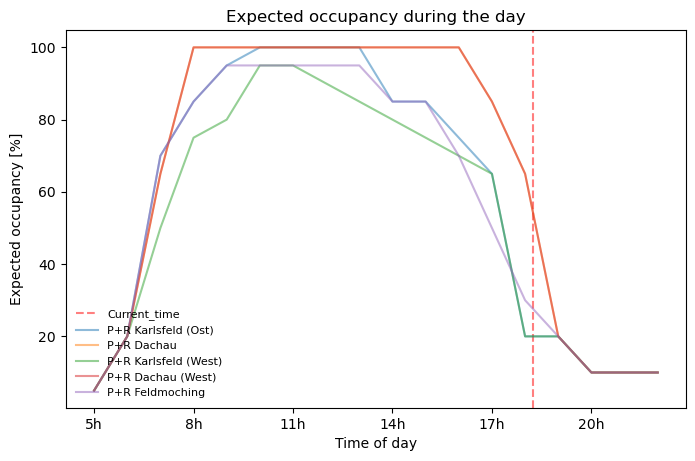

In [8]:
#Want to plot the occupancy
a=results[1]

#Delete parkings of which we don't have the occupancy
a.dropna(how="all", axis=1, inplace=True)

#Give columns plottable name
a.columns=list(np.arange(5,23,1))

#setup grid
fig,ax=plt.subplots(1,1,dpi=100, figsize=(8,5))
tcks=[]
locs=[]
for i in range(5,23,3):
    tcks.append(str(i)+"h")
    locs.append(i)
plt.xticks(locs, tcks)

#plot vertical line at current time if 
if 5<datetime.now().hour<22:
    plt.axvline(x=(datetime.now().hour+(datetime.now().minute/60)), linestyle="--", alpha=0.5, color='r', label='Current_time')
ax.set_xlabel('Time of day')
ax.set_ylabel('Expected occupancy [%]')
ax.set_title('Expected occupancy during the day')

for i,j in enumerate(a.index):
    print()
    ax=a.iloc[i].plot(alpha=0.5)

legend = plt.legend(loc="lower left", edgecolor="black", fontsize=8, framealpha=0)

In [9]:
time1=datetime.now().minute

## Lookup other potential data suppliers

In [10]:
df_11=pd.read_excel('Data/Parkings_in_and_near.xlsx')

In [11]:
for i in df_11.columns:
    print(i, df_11[i].count(), df_11[i].nunique())

Unnamed: 0 15680 15680
id 15680 15680
lat 15680 14359
tags 12099 2935
lon 15680 15484
addr:city 85 26
addr:country 37 1
addr:housenumber 82 44
addr:postcode 81 49
addr:street 98 87
email 4 4
name 1116 859
opening_hours 128 50
operator 910 576
phone 5 5
ref 83 36
website 40 29
amenity 15680 1
bicycle_parking 1 1
charging_station 1 1
parking 11688 16
source 450 33
geometry 15680 15679
osm_type 15680 3
addr:housename 3 3
url 2 2
building 331 11
building:levels 85 10
internet_access 2 1
landuse 6 5
office 1 1
start_date 5 5
taxi 1 1
timestamp 14219 1
version 14219 1
changeset 61 1
new_lon 15680 15675
new_lat 15680 15662
access 10278 18
fee 5156 27
layer 513 7
note 81 78
wheelchair 1319 3
wheelchair:description 58 28
created_by 18 6
toilets:wheelchair 77 2
hgv 124 5
toilets 1 1
supervised 637 5
elevator 1 1
fixme 14 13
surface 1836 20
operator:type 212 13
capacity 2738 172
maxstay 323 67
park_ride 1082 4
bus 13 3
motor_vehicle 16 4
contact:email 2 2
contact:fax 2 2
contact:phone 4 4
contact

In [12]:
df_11.operator.unique()

array([nan, 'Sparkasse', 'Steg 1 Kiosk', 'Contipark', 'El Greco', 'REWE',
       'Contipark Parkgaragen', 'Stadt Grafing bei München',
       'Stadthalle Germering', 'Hauck & Aufhäuser Privatbankiers',
       'mobilecity', 'Kustermann', 'BMW', 'DMG', 'Commerzbank',
       'Landratsamt München', 'Edeka', 'SV Esting', "Erik's",
       'P+R Park & Ride GmbH München', 'HIT', 'Gemeinde Ismaning',
       'P+R GmbH', 'Gebhard', 'Kaufland Geretsried', 'Pasing Arcaden',
       'Neuapostolische Kirche', 'Bundesnachrichtendienst',
       'Stadtsparkasse München', 'WEG Sonnenhof', 'Aldi Süd',
       'Besucherparkplatz', 'Gemeinde Gauting', 'Rewe', 'Forellenhof',
       'Linde Engineering', 'Gemeinde Feldkirchen',
       'Museum Fünf Kontinente', 'Landgasthof Beham',
       'Supermarkt biokultur', 'Kindergarten', 'Real', 'La Villa',
       'Gaststätte Zum grünen Baum', 'Gemeinde Haar', 'Acom Hotel',
       'FitX Sendling-Westpark', 'Brainlab',
       'NH Hotel München, Unterhaching',
       'Ibis M

In [13]:
df_12=df_11.copy()
df_12.dropna(subset=['operator'],inplace=True)
df_12.drop(columns=['tags'],inplace=True)
df_12[df_12['operator'].str.contains("Contipark")].dropna(how='all',axis=1).operator

139                                  Contipark
178                      Contipark Parkgaragen
401                                  Contipark
1094     Contipark Parkgaragengesellschaft mbH
2440     Contipark Parkgaragengesellschaft mbH
2441     Contipark Parkgaragengesellschaft mbH
11039    Contipark Parkgaragengesellschaft mbH
Name: operator, dtype: object

In [16]:
df_12[df_12['operator'].str.contains("Contipark")].dropna(how='all',axis=1)

,Unnamed: 0,id,lat,lon,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,name,...,capacity,park_ride,maxheight,lit,capacity:disabled,smoothness,charge,payment:cash,payment:credit_cards,alt_name
139,139,315935180,48.143604,11.554825,NaN,NaN,6,NaN,Hopfenstraße,Hopfenpost Garage,...,266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178,178,341306421,48.136463,11.574634,NaN,NaN,NaN,NaN,NaN,Tiefgarage Marienplatz,...,NaN,NaN,1.8,NaN,NaN,NaN,4 EUR/h,NaN,NaN,NaN
401,401,1004568474,48.134556,11.571201,München,DE,27,80331.0,Oberanger,Tiefgarage Oberanger,...,423,NaN,2.1 m,NaN,14,NaN,3.50 EUR/hour,yes,yes,NaN
1094,1094,5592427574,48.137463,11.566295,München,DE,11,80331.0,Herzog-Wilhelm-Straße,Stachus Einkaufszentrum,...,700,NaN,2.1,yes,8,excellent,NaN,NaN,NaN,CONTIPARK Tiefgarage Stachus
2440,2440,35331620,47.905857,11.271664,NaN,NaN,NaN,NaN,NaN,Parkplatz am Bahnhof,...,NaN,yes,NaN,NaN,no,NaN,"1,50€ je Tag",NaN,NaN,NaN
2441,2441,35331622,47.906818,11.272203,NaN,NaN,NaN,NaN,NaN,Bahnhofsparkplatz West,...,60,yes,NaN,NaN,no,NaN,"1,50€ je Tag",NaN,NaN,NaN
11039,11039,484946506,47.908279,11.273984,NaN,NaN,NaN,NaN,NaN,Bahnhof P&R,...,130,yes,NaN,NaN,NaN,NaN,"1,5€ je Tag",NaN,NaN,NaN
